<a href="https://colab.research.google.com/github/ThanujSingaravelan/master_thesis_battery_uncertainty/blob/main/thesis_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Clone github repo and Import dependencies**

In [ ]:
!git clone https://github.com/ThanujSingaravelan/master_thesis_battery_uncertainty.git
%cd master_thesis_battery_uncertainty 

In [109]:
import time
import numpy as np
import pandas as pd
import scipy
import copy
from matplotlib import pyplot as plt
from keras.utils.layer_utils import count_params

import uncertainty_modelling_core


# **2. Import Dataset and Preprocess**

1. You experiment with different train and test datatsets splits.


---


2. You can also add different anomalies to the different featuers of the test datasets to check the prediction result later.
  * Current -------------------> '`current`'
  * Voltage -------------------> '`voltage`'
  * State of Charge -----------> '`soc`'
  * Temperature ---------------> '`temperature`'


---


3. You can select choose to use differenet models (each model has its own representative string):

  1. One-stage models ( `two_stage = False` )
  * GMLR ----------------------> "`MLR`"
  * DNN -----------------------> "`DNN`"
  * RNN -----------------------> "`CNN`"
  * Multi Head ----------------> "`MultiHead`"

  2. Two-Stage Models ( `two_stage = True` )
  * Linear R, Dynmaic OCV -----> "`LinRDynOCV`"
  * GECNN ---------------------> "`PhysicsEnsemble`"
  * Dual Channel RNN ----------> "`DualChannelRNNHead`"
  * Dual Channel CNN ----------> "`DualChannelCNNHead`"
  * Dual Channel Multi Head ---> "`DualChannelMultiHead`"


---


4. You can define different number of epochs, window size and stride size.

> Tip: The  ***{x}*** - symbol on the left side task bar has a list of all variables stored in memory.


In [110]:
df_BNN = pd.read_csv('demo_data_BNN_model.csv', index_col=False)
uncertain_data = uncertainty_modelling_core.UncertaintyData()



### Define training set ###
df_train = copy.deepcopy(df_BNN[0:20000])

### Define test sets ###
df_test_1 = copy.deepcopy(df_BNN[15000:20000])
df_test_2 = copy.deepcopy(df_BNN[20000:25000])

### Add artificial anomalies to any series ###
df_test_2.loc[20000:21000,'soc'] = 0.0 

### Choose desired model to experiment ###
model_name = "MLR"
two_stage = False

### You can define differnt number of epochs ###
epochs_1 = 200
epochs_2 = 200

### You can also choose stride and window size for preprocessing ###
stride = 1
window_size = 10


uncertain_data.add_data(df_train)
uncertain_data.compute_tensors_windowed(stride=stride, window_size=window_size, clustering_mode=False)
training_data = uncertain_data.get_tensor_data()

# **3. Train the Model**

In [111]:
Class = getattr(uncertainty_modelling_core, model_name)
model = Class()

model.add_tensor_data(training_data)

m = model.create_core()


start = time.time()
    
model.training_parameters['epochs'] = epochs_1
model.fit_model(model_name=model_name)

if two_stage:
  model.training_parameters['epochs'] = epochs_2
  m = model.update_model(probabilstic_mode=True)
  model.fit_model(model_name=model_name)

stop = time.time()
train_time = stop - start


params = count_params(m.weights)
        

Start training the model...
Epoch 1/200
16/16 [==============================] - 7s 192ms/step - loss: 0.5918 - root_mean_squared_error: 0.7151 - val_loss: 0.3605 - val_root_mean_squared_error: 0.5645
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.1786 - root_mean_squared_error: 0.4800 - val_loss: -0.0739 - val_root_mean_squared_error: 0.3720
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: -0.1308 - root_mean_squared_error: 0.3533 - val_loss: -0.3576 - val_root_mean_squared_error: 0.2760
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: -0.4248 - root_mean_squared_error: 0.2589 - val_loss: -0.7195 - val_root_mean_squared_error: 0.1917
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: -0.7002 - root_mean_squared_error: 0.1970 - val_loss: -1.0764 - val_root_mean_squared_error: 0.1382
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: -0.9884 - root_mean_squared_error: 

# **4. Plot the Outputs and Calcuate Summary Metrics on test dataset**

Select which `test_data` to ealuate

  model_name params  train_time    min_DS    max_DS   mean_DS  stddev_DS  \
0        MLR      8   21.158448  0.000054  7.016243  1.480203   1.908148   

   z_score_max_DS  quantile_1_DS  quantile_25_DS  quantile_50_DS  \
0        2.901263       0.007475        0.182436        0.601532   

   quantile_75_DS  quantile_99_DS  inter_quantile_range  lower_fence  \
0        1.687985        6.904855               1.50555    -2.075889   

   upper_fence  mod_z_score_max_DS  KL_div_DS  mean_model_stddev  
0      3.94631             4.26071   1.222549           2.051318  


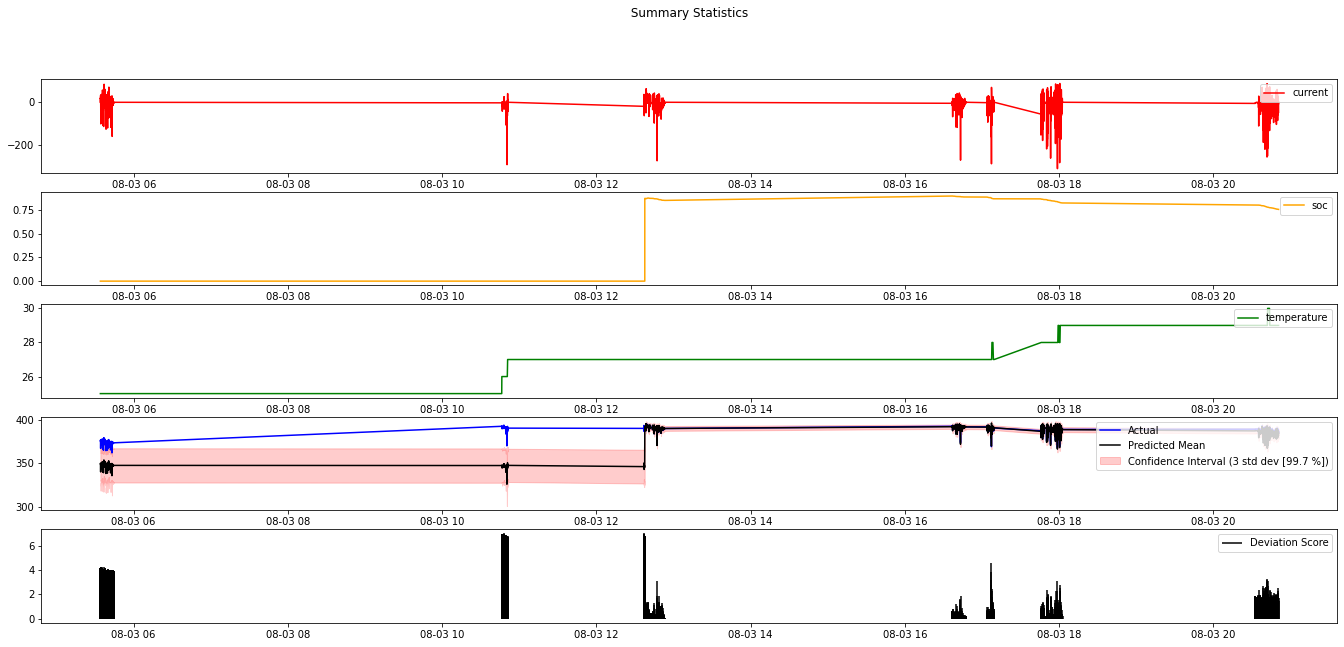

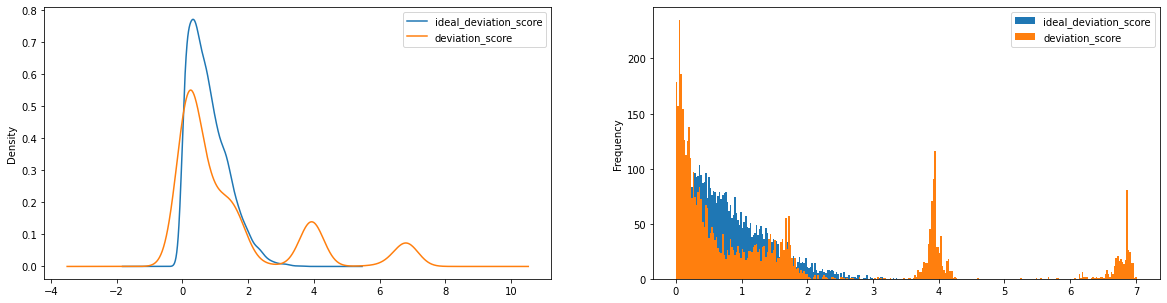

In [112]:
### select test data ###
test_data = df_test_2
########################



predicted_data = model.predict_on_data(df_test_2, model_name=model_name)



result_df = pd.DataFrame(columns=['model_name','params','train_time','min_DS','max_DS','mean_DS',
                                  'stddev_DS','z_score_max_DS','quantile_1_DS','quantile_25_DS','quantile_50_DS',
                                  'quantile_75_DS','quantile_99_DS','inter_quantile_range','lower_fence','upper_fence',
                                  'mod_z_score_max_DS','KL_div_DS','mean_model_stddev'])

min_DS = predicted_data['deviation_score'].min()
max_DS = predicted_data['deviation_score'].max()
mean_DS = predicted_data['deviation_score'].mean()
stddev_DS = predicted_data['deviation_score'].std()
z_score_max_DS = (max_DS - mean_DS) / stddev_DS
quantile_1_DS = predicted_data['deviation_score'].quantile(0.01)
quantile_25_DS = predicted_data['deviation_score'].quantile(0.25)
quantile_50_DS = predicted_data['deviation_score'].quantile(0.50)
quantile_75_DS = predicted_data['deviation_score'].quantile(0.75)
quantile_99_DS = predicted_data['deviation_score'].quantile(0.99)
inter_quantile_range = quantile_75_DS - quantile_25_DS
lower_fence = quantile_25_DS - 1.5*inter_quantile_range
upper_fence = quantile_75_DS + 1.5*inter_quantile_range
mod_z_score_max_DS = (max_DS - quantile_50_DS) / inter_quantile_range

KL_div_DS =  np.nanmean(scipy.special.kl_div(
        predicted_data['ideal_deviation_score'].to_numpy(),
        predicted_data['deviation_score'].to_numpy()))

mean_model_stddev = predicted_data['stddev'].mean()

result_df = pd.concat([result_df,
                        pd.DataFrame([[model_name,
                                      params,
                                      train_time,
                                      min_DS,
                                      max_DS,
                                      mean_DS,
                                      stddev_DS,
                                      z_score_max_DS,
                                      quantile_1_DS,
                                      quantile_25_DS,
                                      quantile_50_DS,
                                      quantile_75_DS,
                                      quantile_99_DS,
                                      inter_quantile_range,
                                      lower_fence,
                                      upper_fence,
                                      mod_z_score_max_DS,
                                      KL_div_DS,
                                      mean_model_stddev]], columns=result_df.columns)], 
                      ignore_index=True)

print(result_df)

fig1 = model.plot_summary()
fig1.set_size_inches(20,10)

fig2 = plt.figure()
ax1 = fig2.add_subplot(121)
predicted_data.plot.density(y=["ideal_deviation_score", "deviation_score"], ax=ax1)
ax2 = fig2.add_subplot(122)
predicted_data.plot.hist(y=["ideal_deviation_score", "deviation_score"], bins=300, ax=ax2)

#fig2.suptitle("KL Divergence of [Deviation Score -> N(0,1)] : " + str(np.round(KL_div_DS,2)))
fig2.set_size_inches(20,5)
